In [73]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from itertools import cycle

In [74]:
# All the 6 methods for comparison in a list
methods = [
    'cv.TM_CCOEFF', 
    'cv.TM_CCOEFF_NORMED', 
    'cv.TM_CCORR',
    'cv.TM_CCORR_NORMED', 
    'cv.TM_SQDIFF', 
    'cv.TM_SQDIFF_NORMED'
]
cycle_methods = cycle(methods)

def next_method():
    return next(cycle_methods)

def get_tmpl_res(img_name, method_name):
    img = cv.imread(f'imgs/{img_name}',0)
    template = cv.imread(f'imgs/red_{img_name}',0)

    w, h = template.shape[::-1]

    method = eval(method_name)
    res = cv.matchTemplate(img,template, method)
    
    _, _, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    
    return res, img
    

In [75]:
def drawMatches(img1, kp1, img2, kp2, matches):

    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    out[:rows1,:cols1] = np.dstack([img1])
    out[:rows2,cols1:] = np.dstack([img2])
    x_arr = []
    y_arr = []
    
    for mat in matches:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        x_arr.append(int(x1))
        y_arr.append(int(y1))

        cv.circle(out, (int(x1),int(y1)), 4, (255, 0, 0, 1), 1)   
        cv.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0, 1), 1)
        cv.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0, 1), 1)

    cv.rectangle(out, (min(x_arr), min(y_arr)), (max(x_arr), max(y_arr)), 255,2)

    return out

In [76]:
def get_sift_res(img):
    img1 = cv.imread(f'imgs/{img}')
    img2 = cv.imread(f'imgs/red_{img}')

    sift = cv.SIFT_create()

    gray1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

    kp1, des1 = sift.detectAndCompute(gray1,None)
    kp2, des2 = sift.detectAndCompute(gray2,None)

    bf = cv.BFMatcher()
    matches = bf.match(des1,des2)
    matches = sorted(matches, key=lambda val: val.distance)
    img3 = drawMatches(img1,kp1,img2,kp2,matches[:25])
    return img3

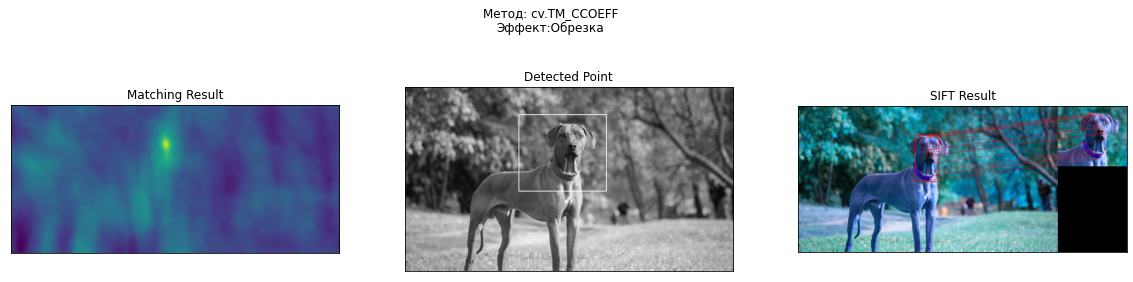

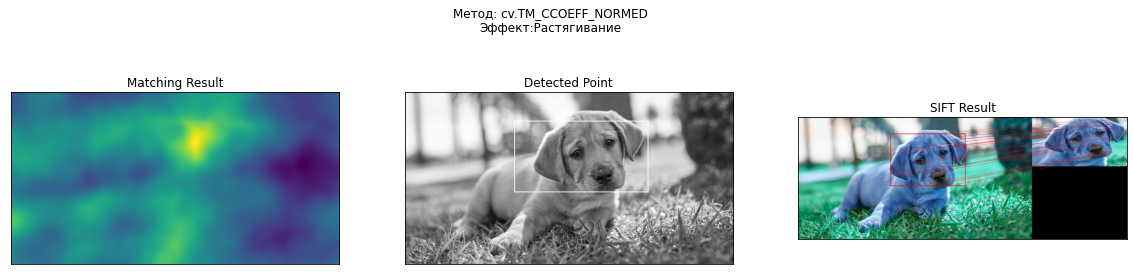

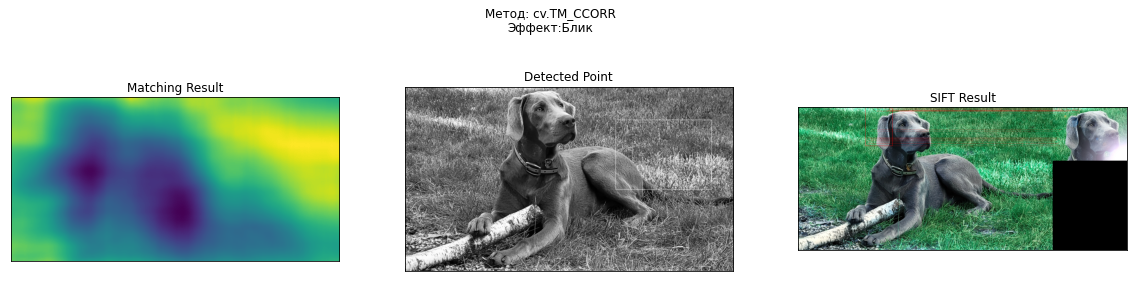

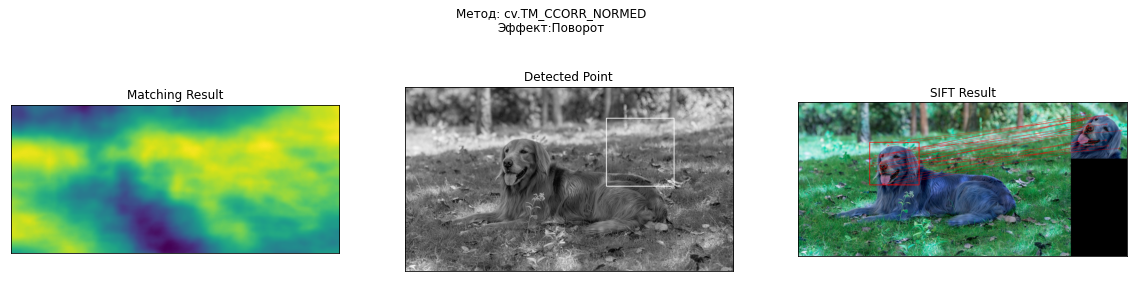

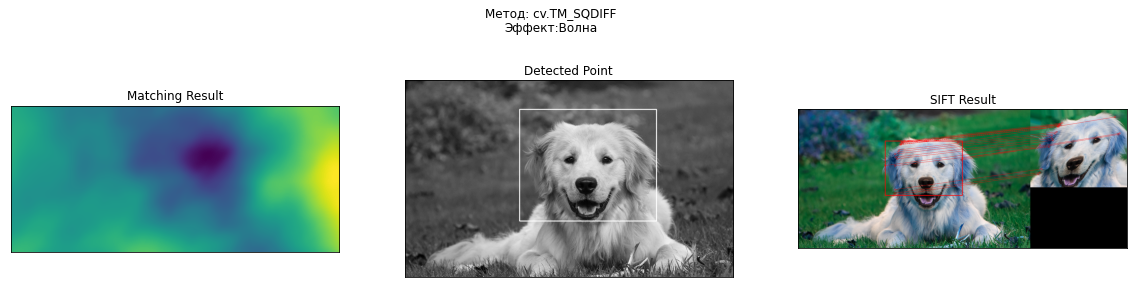

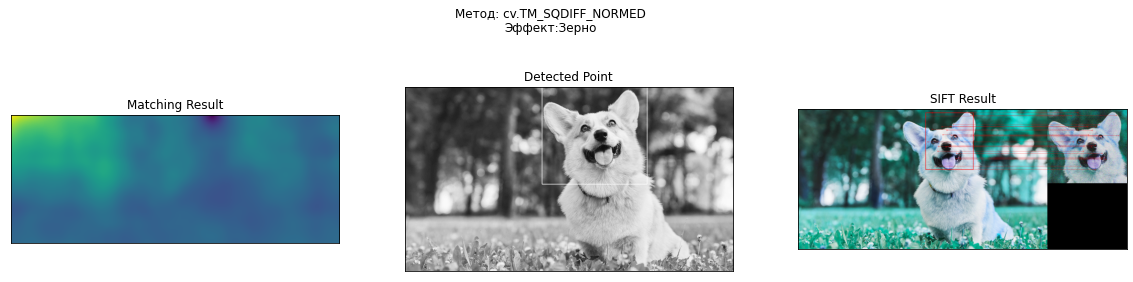

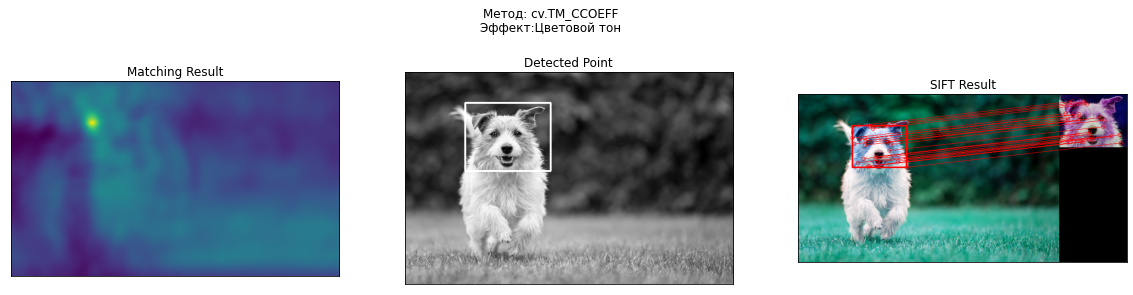

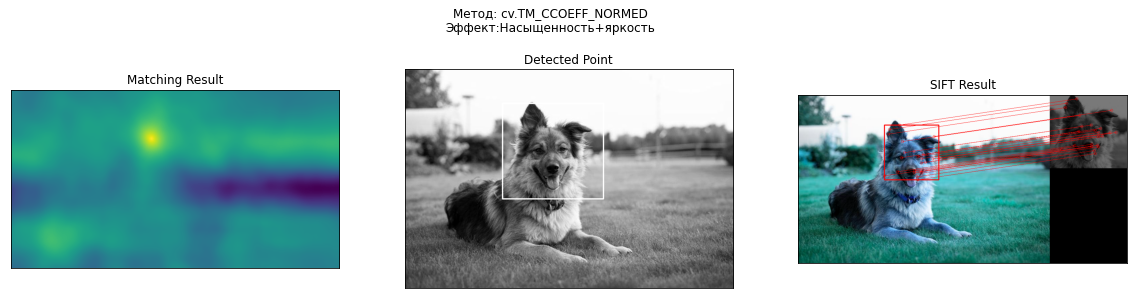

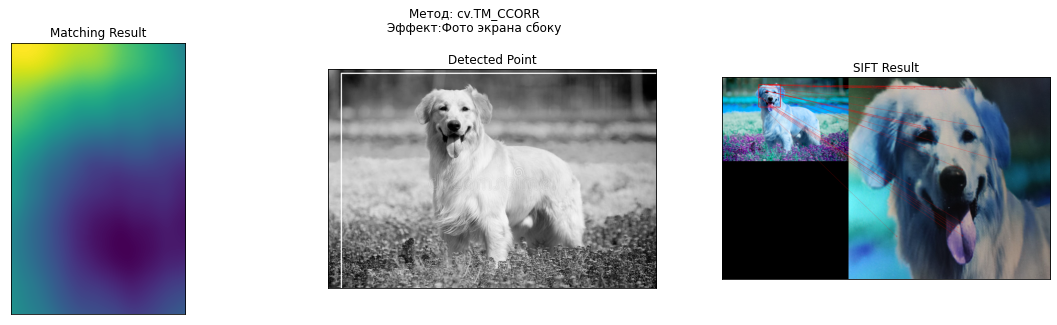

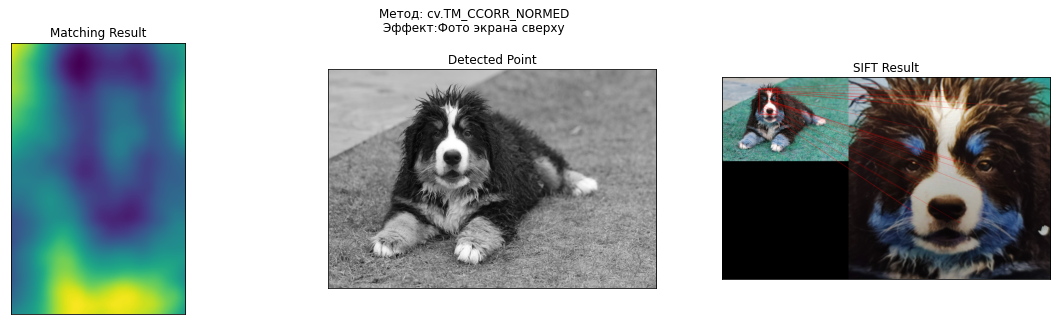

In [77]:
imgs = {
    'sample1.jpg': 'Обрезка',
    'sample2.jpg': 'Растягивание',
    'sample3.jpg': 'Блик',
    'sample4.jpg': 'Поворот',
    'sample5.jpg': 'Волна',
    'sample6.jpg': 'Зерно',
    'sample7.jpg': 'Цветовой тон',
    'sample8.jpg': 'Насыщенность+яркость',
    'sample9.jpg': 'Фото экрана сбоку',
    'sample10.jpg': 'Фото экрана сверху',
}

for img, desc in imgs.items():
    meth_name = next_method()
    
    sift_res = get_sift_res(img)
    tmpl_res, image = get_tmpl_res(img, meth_name)

    fig = plt.figure(figsize=(20, 5))

    plt.subplot(131)
    plt.imshow(tmpl_res)
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(132)
    plt.imshow(image,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(sift_res)
    plt.title('SIFT Result'), plt.xticks([]), plt.yticks([])
    
    plt.suptitle(f'Метод: {meth_name}\nЭффект:{desc}')
    plt.show()